# Kernel Trick and SVM

Cheryl KOUADIO  
2024-10-04

# Activity 1 : Kernel Ridge Regression (KRR)

In regression and classification, we often use linear models to predict
the target variable. However, in many cases, the relationship between
the target variable and the explanatory variables is non-linear. In such
cases, we can use the kernel trick whenever there is a scalar product
between the explanatory variables. The kernel trick allows us to
transform the data into a higher-dimensional space where the
relationship is linear.

In this first activity, we will explore the kernel trick to transform
the data and then use a linear model to predict the target variable. In
particular, we will use Kernel ridge regression (KRR) which is a
combination of ridge regression and the kernel trick. The optimization
problem of KRR is given by: $$
\hat \theta = \min_{\theta} \frac{1}{n} \sum_{i=1}^n (y_i - x_i^T\theta)  + \lambda \sum_{j=1}^d \theta_j
$$ where $x_i$ is the $i$-th row of the matrix $X$ and $y_i$ is the
$i$-th element of the vector $y$. The parameter $\lambda$ is the
regularization parameter. The solution of the optimization problem is
given by:

$$
\hat \theta = (X^TX + \lambda I_d)^{-1}X^Ty = X^T (X X^T + \lambda I_n)^{-1}y
$$

where $I_d$ and $I_n$ are the identity matrix.

In prediction, the target variable is given by: $$
\hat{y}(x^*) = X^T \hat{\theta} = \langle x^*, \hat{\theta} \rangle = \left\langle x^*, \sum_{i=1}^{n} \alpha_i x_i \right\rangle = \sum_{i=1}^{n} \alpha_i \langle x_i, x^* \rangle
$$ where $\alpha_i = \sum_{j=1}^{n} \theta_j x_{ij}$. We easily see that
the prediction is a linear combination of the scalar product between the
test point $x^*$ and the training points $x_i$, we can use the kernel
trick to transform the data into a higher-dimensional space where the
relationship is linear. The prediction becomes:

$$
\hat{y}(x^*) = \sum_{i=1}^{n} \alpha_i K(x_i, x^*)
$$

where $K(x_i, x^*)$ is the kernel function.

## I. Fit the Kernel Ridge Regression (KRR)

In problem which involves a distance between point, it is a common
practice to normalize the data. In this notebook, we are going to
normalize the data by dividing the time by 60 to convert it from minutes
to hours (and have values between 0 and 1). We are going to use the
`KernelRidge` class from the `sklearn` library to fit the KRR model. We
will start by using the Gaussian/RBF kernel which is defined by: $$
K(x, x') = \exp\left(-\gamma||x - x'||^2\right)
$$ where $\gamma$ is an hyperparameter.

In [1]:
# Libraries
import pandas as pd 
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#!pip install umap-learn
import umap.umap_ as umap
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load the data
mcycle_data = pd.read_csv("Data/mcycle.csv")
mcycle_data["times"] = mcycle_data["times"]/60 
mcycle_data.describe()

In [3]:
# Split the data into train and test sample
X = mcycle_data[["times"]]
y = mcycle_data[["accel"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Training and testing RBF kernel ridge regression

Since we have two hyperparameter ($\gamma$ and $\lambda$) to tune, we
can use the GridSearchCV function from scikit-learn to find the best
hyperparameter.

In [4]:
rbf_krr_model = KernelRidge(kernel="rbf")
grid_eval = np.logspace(-2, 4, 50)
param_grid = {"alpha": grid_eval, "gamma": grid_eval}
rbf_krr_model_cv = GridSearchCV(rbf_krr_model, param_grid).fit(X_train,y_train)
print(f"Best parameters by CV : {rbf_krr_model_cv.best_params_}")

Best parameters by CV : {'alpha': np.float64(0.07196856730011521), 'gamma': np.float64(35.564803062231285)}

In [5]:
best_model = KernelRidge(kernel="rbf", alpha=rbf_krr_model_cv.best_params_["alpha"], gamma=rbf_krr_model_cv.best_params_["gamma"])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f"Root mean square error: {math.sqrt(mean_squared_error(y_test, y_pred)): .2f}")

Root mean square error:  22.98

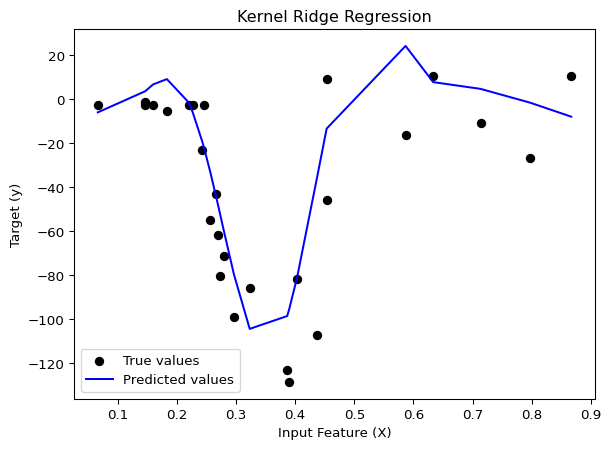

In [6]:
# Sort X_test and corresponding y_pred values
sorted_indices = np.argsort(X_test.values.flatten())
X_test_sorted = X_test.values.flatten()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

plt.scatter(X_test, y_test, color="black", label="True values")
plt.plot(X_test_sorted, y_pred_sorted, color="blue", label="Predicted values")
plt.title("Kernel Ridge Regression")
plt.xlabel("Input Feature (X)")
plt.ylabel("Target (y)")
plt.legend(loc="best")
plt.show()

## II. Ridge regression

Now we are going to use the basic ridge regression to predict the target
variable. There is only one hyperparameter to tune which is the
regularization parameter $\lambda$.

RMSE Ridge regression :  46.17

Text(0.5, 1.0, 'Ridge Regression')

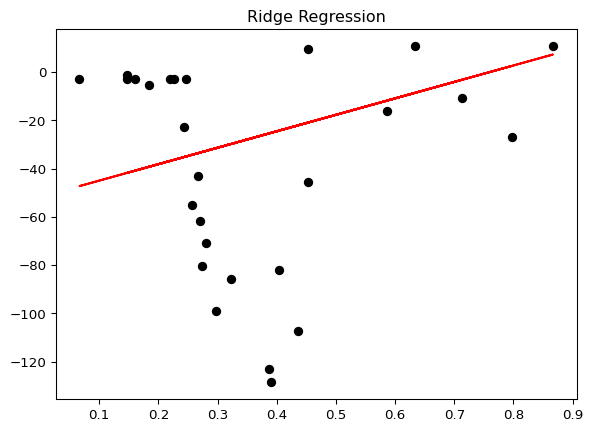

In [7]:
ridge_model = RidgeCV(alphas=grid_eval).fit(X_train, y_train)
y_pred_ridge=ridge_model.predict(X_test)
print( f'RMSE Ridge regression : {math.sqrt(mean_squared_error(y_test, y_pred_ridge)) : .2f}')

# Plot the results
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test, y_pred_ridge, color="red")
plt.title("Ridge Regression")

As we can see, the solelly use of the ridge regression is not enough to
predict the target variable. We can try to transform the data by using a
sinusoïdal transformation. If we try a transformation of the covariable
$x$ by \$ = (x) \$ and apply the ridge regression, we have a slightly
different problem. But still, the performance of the model is not good.

In [8]:
# create a function that apply transformation to the features
def apply_cos(x,j):
    pi = np.pi
    return np.sqrt(2)*np.cos(j*pi*x)/(j*pi)

# perform ridge regression with cosinus modification from j = 1 to 10
X_train_cos = pd.DataFrame()
X_test_cos = pd.DataFrame()
for j in range(1,11):
    X_train_cos[f"X{j}"] = X_train["times"].apply(lambda x: apply_cos(x,j))
    X_test_cos[f"X{j}"] = X_test["times"].apply(lambda x: apply_cos(x,j))

RMSE Ridge regression with x tilde: 45.87

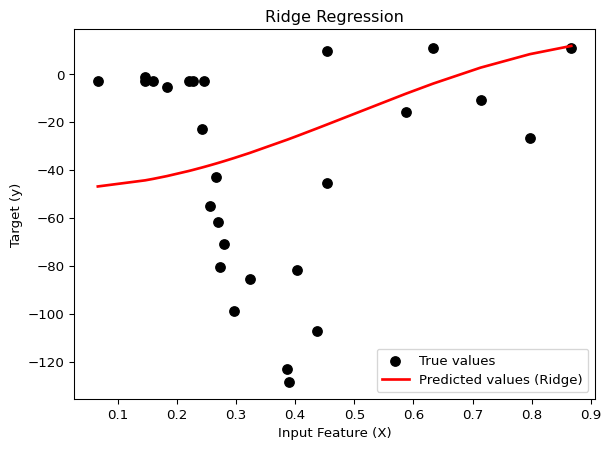

In [9]:
# Train the Ridge regression model
ridge_model1 = RidgeCV(alphas=grid_eval).fit(X_train_cos[["X1"]], y_train)
y_pred_ridge1 = ridge_model1.predict(X_test_cos[["X1"]])

rmse_ridge = math.sqrt(mean_squared_error(y_test, y_pred_ridge1))
print(f'RMSE Ridge regression with x tilde: {rmse_ridge:.2f}')
y_pred_ridge1_sorted = y_pred_ridge1[sorted_indices]

plt.scatter(X_test, y_test, color="black", label="True values", s=50)
plt.plot(X_test_sorted, y_pred_ridge1_sorted, color="red", label="Predicted values (Ridge)", linewidth=2)
plt.title("Ridge Regression")
plt.xlabel("Input Feature (X)")
plt.ylabel("Target (y)")
plt.legend(loc="best")
plt.show()

Even though, the only transformation applied is the cosinus
transformation, the RMSE is lower than the RMSE of the simple Ridge
Regression. This is due to the fact that the cosinus transformation is
able to capture a little bit of the periodicity of the data. Let’s try
to use many sinusoidal transformation to see if we can improve the
performance of the model. We will fit y using
$\tilde{x} = \left[ \frac{\sqrt(2)}{J\pi}\cos(J\pi x)  \right]_{J=1,\dots,10}$

RMSE Ridge regression :  22.96

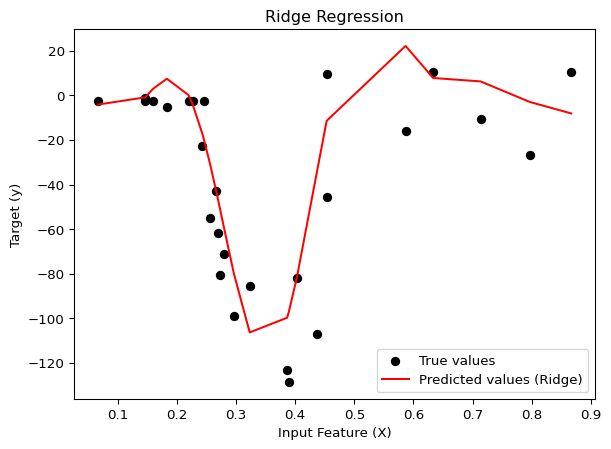

In [10]:
# New ridge with many transformated features
ridge_model2 = RidgeCV(alphas=grid_eval).fit(X_train_cos, y_train)
y_pred_ridge2 = ridge_model2.predict(X_test_cos)
y_pred_ridge2_sorted = y_pred_ridge2[sorted_indices]
print( f'RMSE Ridge regression : {math.sqrt(mean_squared_error(y_test, y_pred_ridge2)): .2f}')

# Plot the results
plt.scatter(X_test, y_test, color="black",label="True values")
plt.plot(X_test_sorted, y_pred_ridge2_sorted,color="red",label="Predicted values (Ridge)")
plt.title("Ridge Regression")
plt.xlabel("Input Feature (X)")
plt.ylabel("Target (y)")
plt.legend(loc="best")
plt

We observe that the more we increase the number of transformations, the
more the performance of the model is improved and close to the
performance of the kernel ridge regression using the gaussian kernel.
The performance of the model is similar to the performance of the kernel
ridge regression. This is due to the fact that the kernel ridge
regression is equivalent to use an infinite number of transformations on
the features. It is hence useful to use the kernel trick when we have a
non-linear relationship between the target variable and the features.

## III. Insigths :

Linear regression with such sinusoidal transformation is equivalent to
the kernel ridge regression with a specific kernel : the sobolev kernel.
The sobolev kernel is defined by: $$
K(x, x') = 1 + B_1(x)B_2(x') + \frac{1}{2}B_2(|x-x'|) = 1 + B_2(\frac{|x-x'|}{2}) + B_2(\frac{x+x'}{2})
$$

where $B_1 = x - 1/2$ and $B_2 = x^2 - x - 1/6$.

Using the fourier series expansion for $x \in [0,1]$, we have : $$
B_2(x) = \sum_{k=1}^{\infty} \frac{\cos(2k\pi x)}{(k\pi)^2}
$$

### Kernel de sobolev

In [11]:
def sobolev_kernel(x,y):
    def B2(x):
        return x**2 - x + 1/6
    
    def B1(x):
        return x - 1/2
    
    return 1+ B2(abs(x-y)/2) + B2((x+y)/2)

In [12]:
krr_model_sobolev = KernelRidge(kernel=sobolev_kernel)
param_grid = {"alpha": grid_eval}
grid_sobolev = GridSearchCV(krr_model_sobolev, param_grid).fit(X_train,y_train)
grid_sobolev.best_params_

{'alpha': np.float64(0.07196856730011521)}

Root mean square error :  61.98

Text(0.5, 1.0, 'Sobolev Kernel Ridge Regression')

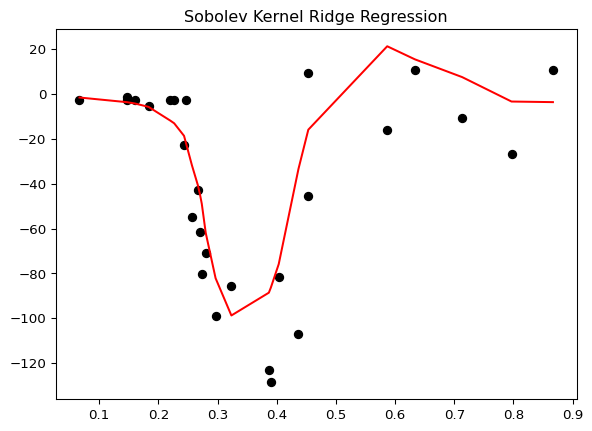

In [13]:
# compute rmse
# best_sobolev_krr = KernelRidge(kernel=sobolev_kernel, alpha=grid_sobolev.best_params_["alpha"])
# best_sobolev_krr.fit(X_train, y_train)
y_pred_sobolev = grid_sobolev.predict(X_test)
y_pred_sobolev_sorted = y_pred_sobolev[sorted_indices]
print( f'Root mean square error : {math.sqrt(mean_squared_error(y_test, y_pred_sobolev_sorted)): .2f}')


# Plot the results
plt.scatter(X_test, y_test, color="black")
plt.plot(X_test_sorted, y_pred_sobolev_sorted,color="red")
plt.title("Sobolev Kernel Ridge Regression")

# Activity 2 : Support Vector Machine

The support vector machines (SVM) is a supervised learning algorithm
that can be used for classification. The SVM is based on the concept of
finding the hyperplane that best separates the data into two classes. In
fact, if the problem is **linearly separable**, the SVM finds the
hyperplane that maximizes the margin between the two classes. The margin
is the distance between the hyperplane and the closest point of each
class (support vectors).

When the problem is non-linearly separable, the SVM uses the same
functionnement but allows some points to be misclassified. When the
problem is too complex, the SVM uses the kernel trick to transform the
data into a higher-dimensional space where the relationship is linear.

## I. Toy dataset

Here is the toy dataset that we are going to use to illustrate the SVM.
The dataset is composed of two features and the target variable is
binary. As we can see, the dataset is not linearly separable. We are
going to use the SVM with a gaussian kernel to classify the data, and
compare it to a classic classifier such as the k-nearest neighbors and
the logistic regression.

Text(0.5, 1.0, 'Two moons dataset')

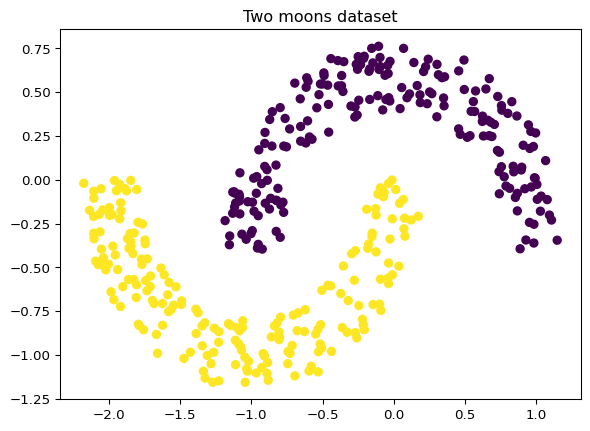

In [14]:
two_moon_data = pd.read_csv("Data/DataTwoMoons.csv",header=None)
two_moon_data.columns = ["X1","X2","y"]

plt.scatter(two_moon_data["X1"], two_moon_data["X2"], c=two_moon_data["y"])
plt.title("Two moons dataset")

In [15]:
# Split the data into train and test sample
X_train, X_test, y_train, y_test = train_test_split(two_moon_data[["X1","X2"]], two_moon_data["y"], test_size=0.2, random_state=42)

### 1. K-nearest neighbors

In [16]:
# KNN with cross validation

knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 50)}
knn_cv = GridSearchCV(knn, param_grid).fit(X_train, y_train)
print(f"Best parameters by CV : {knn_cv.best_params_}")

# Compute the accuracy
y_pred = knn_cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix to see detailed classification performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best parameters by CV : {'n_neighbors': np.int64(1)}
Accuracy: 1.00
Confusion Matrix:
[[44  0]
 [ 0 36]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        36

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


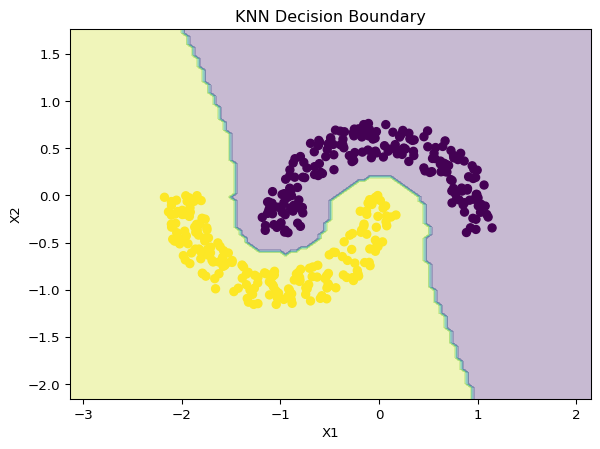

In [17]:
disp_knn = DecisionBoundaryDisplay.from_estimator(
    knn_cv,
    X_train,
    response_method="predict",
    alpha = 0.3
)
disp_knn.ax_.scatter(two_moon_data["X1"],two_moon_data["X2"], c=two_moon_data["y"])
plt.title("KNN Decision Boundary")
plt.show()

### 2. Logistic regression

In [18]:
# compute logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix to see detailed classification performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.91
Confusion Matrix:
[[39  5]
 [ 2 34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        44
           1       0.87      0.94      0.91        36

    accuracy                           0.91        80
   macro avg       0.91      0.92      0.91        80
weighted avg       0.92      0.91      0.91        80


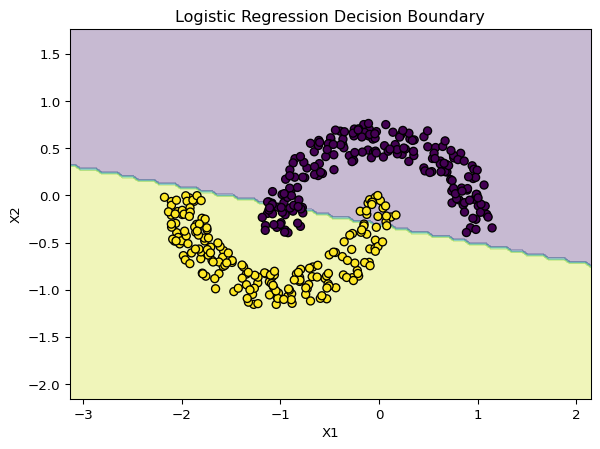

In [19]:
disp_log_reg = DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_train,
    response_method="predict",
    alpha = 0.3
)
disp_log_reg.ax_.scatter(two_moon_data["X1"],two_moon_data["X2"], c=two_moon_data["y"], edgecolor="k")
plt.title("Logistic Regression Decision Boundary")
plt.show()

### 3. SVM

In [20]:
grid_eval = np.logspace(-2, 4, 50)
param_grid = {"C": grid_eval, "gamma": grid_eval}
svm_model = SVC(kernel="rbf")
svm_model_cv = GridSearchCV(svm_model, param_grid).fit(X_train,y_train)
print(f"Best parameters by CV : {svm_model_cv.best_params_}")

Best parameters by CV : {'C': np.float64(0.030888435964774818), 'gamma': np.float64(3.727593720314938)}

In [21]:
# Compute the accuracy
y_pred = svm_model_cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix to see detailed classification performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00
Confusion Matrix:
[[44  0]
 [ 0 36]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        36

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


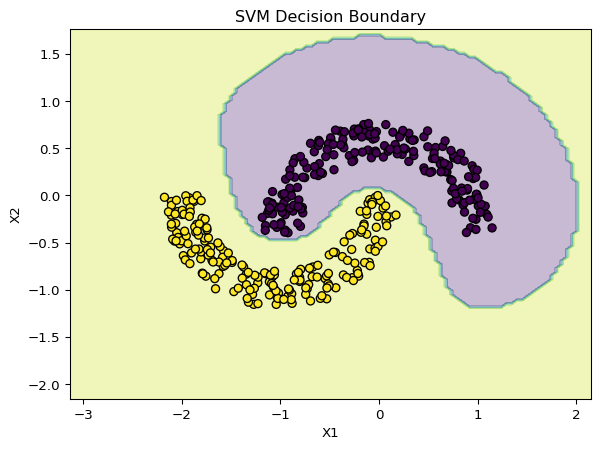

In [22]:
disp_svm = DecisionBoundaryDisplay.from_estimator(
    svm_model_cv,
    X_train,
    response_method="predict",
    alpha = 0.3
)
disp_svm.ax_.scatter(two_moon_data["X1"],two_moon_data["X2"], c=two_moon_data["y"], edgecolor="k")
plt.title("SVM Decision Boundary")
plt.show()

### 4. Conclusion

As we can see, the SVM with the gaussian kernel is able to classify the
data with a good accuracy. The SVM is able to capture the non-linear
relationship between the target variable and the features.

The logistic regression, in this case, is not able to classify the data
because the relationship between the target variable and the features is
non-linear.

The k-nearest neighbors is able to classify the data with a performance
similar to the SVM. The SVM and the KNN are a good choice when we have a
non-linear relationship between the target variable and the features.

**Whenever we have a classification problem, it is hence always useful
to try the SVM and the KNN.**

## II. Image dataset

The SVM is also useful for image classification. In this part, we are
going to use the famous MNIST dataset to classify the images. The MNIST
dataset is composed of 20 000 images (10 000 in the training dataset,
and 10 000 also in the test dataset) of handwritten digits from 0 to 9.
Each image is a resolution 28x28 pixels that is represented by a matrix
of shape (28, 28), with each element being the pixel intensity (values
from 0 to 255). We are going to use the SVM with the gaussian kernel to
classify the images.

We will start by normalizing the data to ensure that all the features
contribute equally, and then use the GridSearchCV function from
scikit-learn to find the best hyperparameter.

In [23]:
data_train = pd.read_csv("Data/mnist_train_small.csv")
data_test = pd.read_csv("Data/mnist_test.csv")

print("Description of train dataset : \n")
data_train.iloc[:,1:].describe()
data_train["label"].value_counts()

Description of train dataset : 


label
8    113
0    111
1    110
7    106
9    100
2     99
4     95
5     93
6     90
3     83
Name: count, dtype: int64

In [24]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train  = scaler.fit_transform(data_train.iloc[:, 1:])
y_train = data_train["label"]
X_test  = scaler.transform(data_test.iloc[:, 1:])
y_test = data_test["label"]

As we can see from the umap plot, which is a dimensionality reduction
technique, the data is not always linearly separable. We are going to
use the SVM with the gaussian kernel to classify the images.

In [25]:
# visualize the data with UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_train)

Text(0.5, 1.0, 'UMAP projection of the MNIST dataset')

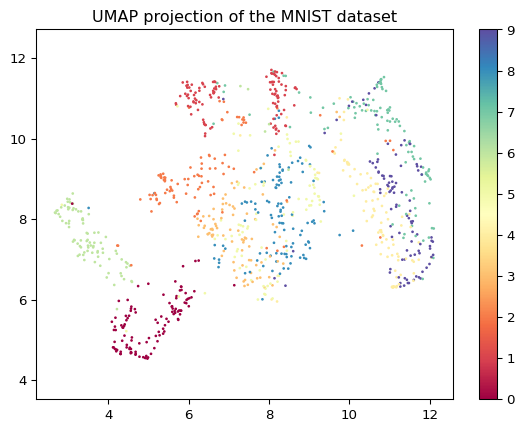

In [26]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=data_train["label"], cmap='Spectral', s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title('UMAP projection of the MNIST dataset')

In [27]:
svm_model = SVC(kernel="rbf")
from itertools import product

grid_eval_C = [c * factor for c, factor in product([0.1, 1, 10], [1, 5])]
grid_eval_gamma = [gamma * factor for gamma, factor in product([10**-3, 10**-2, 10**-1], [1, 5])]


param_grid = {"C": grid_eval_C, "gamma": grid_eval_gamma}
svm_model_cv = GridSearchCV(svm_model, param_grid).fit(X_train, y_train)
print(f"Best parameters by CV : {svm_model_cv.best_params_}")

Best parameters by CV : {'C': 5, 'gamma': 0.001}

As we can see, the model performs well with an accuracy of 0.88 . As
expected from the umap visualization, the model is able to separate the
classes well, however there are some errors in the classification. The
confusion matrix shows that the model has some difficulty to distinguish
between some digits such as 4 and 9, 3.

The SVM is a good choice for image classification, however, the model is
not able to capture the complexity of the data. In this case, we can use
a deep learning model such as the convolutional neural network (CNN)
which is able to capture the complexity of the data.

In [28]:
# compute the accuracy
y_pred = svm_model_cv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix to see detailed classification performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.88
Confusion Matrix:
[[ 931    0   20    1    1   12    9    2    4    0]
 [   0 1121    4    2    0    1    6    0    1    0]
 [  14    6  949   20    7    2    6   10   17    1]
 [   6    2   75  829    2   29    3   30   25    9]
 [   3    5   32    0  881    3    9    4    5   40]
 [   4    3   75   31    5  718   20    9   16   11]
 [  20    5  101    0    8   11  808    0    5    0]
 [   1   12   61    1   10    2    0  913    0   28]
 [   8   14   37   13   11   23    5   18  829   16]
 [   9    6   30   12   37    4    0   57    1  853]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       980
           1       0.95      0.99      0.97      1135
           2       0.69      0.92      0.79      1032
           3       0.91      0.82      0.86      1010
           4       0.92      0.90      0.91       982
           5       0.89      0.80      0.85       892
           6       0.93      0.84 

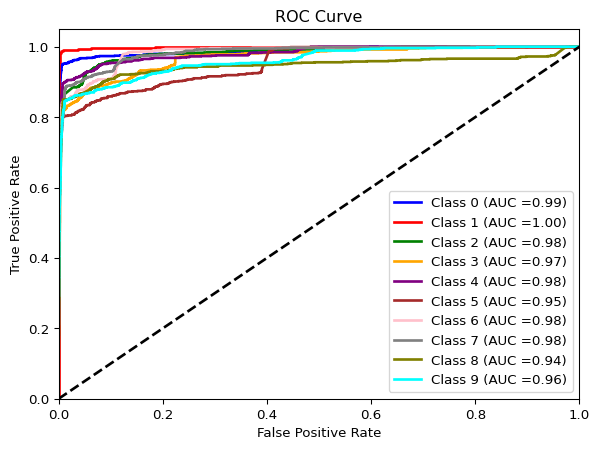

In [29]:
# plot ROC CURVE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_score = svm_model_cv.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC ={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()